In [46]:
import pandas as pd
import datetime
from pandas_profiling import ProfileReport
import geopandas as gpd
import numpy as np
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
import matplotlib.pyplot as plt
import seaborn as sns
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder, OneHotCategoricalEncoder, MeanCategoricalEncoder
from feature_engine import variable_transformers as vt
from feature_engine.outlier_removers import Winsorizer
from shapely.geometry import Point, MultiPolygon, Polygon
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [2]:
#Read both dataframes
#Combine the details dataframe with saleshistory dataframe
details = pd.read_csv('Data/house_data_details_cleaned.csv')
history = pd.read_csv('Data/house_data_saleshistory_cleaned.csv')

In [3]:
#Convert pandas dataframe into geopandas df
gdf = gpd.GeoDataFrame(details, geometry=[Point(xy) for xy in zip(details.longitude, details.latitude)])

#Import geojson map of los angeles
hoods = gpd.read_file('Los Angeles Neighborhood Map.geojson')
hoods = hoods.rename(columns={'name': 'neighborhood',
                              'latitude': 'longitude',
                              'longitude': 'latitude'})
hoods[['latitude', 'longitude']] = hoods[['latitude', 'longitude']].astype(float)
hoods['polygon'] = hoods['geometry'].apply(lambda x: Polygon(x[0]))

#This function will classify every house and label it an appropriate neighborhood
def find_neighborhood(coordinates):
    for index, hood in hoods.iterrows():
        if hood['polygon'].contains(coordinates):
            return hood['neighborhood']
        else:
            continue 

gdf['neighborhood'] = gdf['geometry'].apply(find_neighborhood)

#Code below will assign the nearest neighborhood for those with a missing value
for index, row in gdf.iterrows():
    if row['neighborhood'] == None:
        lat = row['latitude']
        lng = row['longitude']
        hoods2 = hoods.copy()
        hoods2['distance'] = np.sqrt((hoods2['latitude'] - lat)**2 + (hoods2['longitude'] - lng)**2)
        hoods2 = hoods2.sort_values(by='distance').reset_index(drop=True)
        gdf.loc[index, 'neighborhood'] = hoods2['neighborhood'][0]

gdf.head()

,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,date,sale_price,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,geometry,neighborhood
0,33.97462,-118.13368,6224 Nye St,Condominium,1357.00000,2221560.00000,1988.00000,6357012043,1111054477.00000,Los Angeles,45351,1.00000,532304.00000,1,CMR3,2020-09-28,469000.00000,439000.00000,7,High,15,1,Average,https://www.realtytrac.com/property/ca/commerc...,3.00000,3.00000,POINT (-118.13368 33.97462),Commerce
1,34.15656,-118.39689,4723 Laurel Canyon Blvd,Restaurant,2250.00000,9799.00000,1959.00000,2356037034,1111055289.00000,Los Angeles,7360,1.00000,143400.00000,10,LAC2,2020-09-28,1910000.00000,nan,5,NaN,6,1,Excellent,https://www.realtytrac.com/property/ca/valley-...,nan,nan,POINT (-118.39689 34.15656),Valley Village
2,34.67778,-118.45116,18118 Elizabeth Lake Rd,Apartment house (5+ units),1454.00000,13635.00000,1948.00000,3242015023,1111055911.00000,Los Angeles,NaN,2.00000,920102.00000,4,LCC4,2020-09-28,325000.00000,nan,0,NaN,2,1,NaN,https://www.realtytrac.com/property/ca/lake-hu...,7.00000,6.00000,POINT (-118.45116 34.67778),Lake Hughes
3,34.07296,-118.06690,9259 Ramona Blvd,Single Family Residence,1682.00000,7000.00000,1978.00000,8594027016,1111055994.00000,Los Angeles,ROSEMEAD,2.00000,432901.00000,6,RMPOD,2020-09-28,738000.00000,752000.00000,3,Moderate,11,1,Excellent,https://www.realtytrac.com/property/ca/rosemea...,3.00000,2.00000,POINT (-118.06690 34.07296),Rosemead
4,33.77772,-118.15491,825 Obispo Ave,"Triplex (3 units, any combination)",1958.00000,6754.00000,1938.00000,7258013016,1111056010.00000,Los Angeles,1,2.00000,576904.00000,18,LBR2N,2020-09-28,1185000.00000,989000.00000,11,Slightly High,8,1,Average,https://www.realtytrac.com/property/ca/long-be...,4.00000,3.00000,POINT (-118.15491 33.77772),Long Beach


In [29]:
print(details.shape, history.shape)
raw_data = pd.merge(details, history, on='parcel_number', how='left')
print(raw_data.shape)

#There are some properties in the saleshistory dataframe that are not 
#in the details dataframe. That is why the total number of observations
#do not add up after the merge

(17855, 28) (31328, 3)
(37538, 30)


In [30]:
#We'll be keeping the values from the right dataframe(for columns date and sale_price) since they exist in both dataframes
#There are a lot of null values for properties that are not in the saleshistory.We'll fill those missing values 
#with the values from the left dataframe and then drop the duplicate features from the left dataframe

print(f'Number of missing values for price after the merge and before the imputation: {raw_data.price.isnull().sum()}')
missing = raw_data.loc[raw_data['price'].isnull()].index
raw_data['date_y'] = raw_data['date_y'].fillna(raw_data['date_x'])
raw_data['price'] = raw_data['price'].fillna(raw_data['sale_price'])

raw_data.drop(['date_x', 'sale_price'], axis=1, inplace=True)
raw_data.rename(columns={'date_y': 'date', 'price':'sale_price'}, inplace=True)

print(f'Number of missing values for price after imputing the missing values: {raw_data.sale_price.isnull().sum()}')
raw_data.head()

Number of missing values for price after the merge and before the imputation: 7425
Number of missing values for price after imputing the missing values: 579


,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,realtyID,county,subdivision,census,tract,lot,zoning,estimated_value,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,geometry,neighborhood,date,sale_price
0,33.97462,-118.13368,6224 Nye St,Condominium,1357.00000,2221560.00000,1988.00000,6357012043,1111054477.00000,Los Angeles,45351,1.00000,532304.00000,1,CMR3,439000.00000,7,High,15,1,Average,https://www.realtytrac.com/property/ca/commerc...,3.00000,3.00000,POINT (-118.13368 33.97462),Commerce,2020-09-28,469000.00000
1,34.15656,-118.39689,4723 Laurel Canyon Blvd,Restaurant,2250.00000,9799.00000,1959.00000,2356037034,1111055289.00000,Los Angeles,7360,1.00000,143400.00000,10,LAC2,nan,5,NaN,6,1,Excellent,https://www.realtytrac.com/property/ca/valley-...,nan,nan,POINT (-118.39689 34.15656),Valley Village,2020-09-28,1910000.00000
2,34.67778,-118.45116,18118 Elizabeth Lake Rd,Apartment house (5+ units),1454.00000,13635.00000,1948.00000,3242015023,1111055911.00000,Los Angeles,NaN,2.00000,920102.00000,4,LCC4,nan,0,NaN,2,1,NaN,https://www.realtytrac.com/property/ca/lake-hu...,7.00000,6.00000,POINT (-118.45116 34.67778),Lake Hughes,2020-09-28,325000.00000
3,34.07296,-118.06690,9259 Ramona Blvd,Single Family Residence,1682.00000,7000.00000,1978.00000,8594027016,1111055994.00000,Los Angeles,ROSEMEAD,2.00000,432901.00000,6,RMPOD,752000.00000,3,Moderate,11,1,Excellent,https://www.realtytrac.com/property/ca/rosemea...,3.00000,2.00000,POINT (-118.06690 34.07296),Rosemead,2020-09-28,738000.00000
4,33.77772,-118.15491,825 Obispo Ave,"Triplex (3 units, any combination)",1958.00000,6754.00000,1938.00000,7258013016,1111056010.00000,Los Angeles,1,2.00000,576904.00000,18,LBR2N,989000.00000,11,Slightly High,8,1,Average,https://www.realtytrac.com/property/ca/long-be...,4.00000,3.00000,POINT (-118.15491 33.77772),Long Beach,2020-09-28,1185000.00000


In [31]:
df = raw_data.copy()
df.describe()

,latitude,longitude,home_size,lot_size,year_built,parcel_number,realtyID,census,tract,estimated_value,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms,sale_price
count,37538.00000,37538.00000,35984.00000,37339.00000,36313.00000,37538.00000,37529.00000,37538.00000,37538.00000,35231.00000,37538.00000,37538.00000,37538.00000,35040.00000,35040.00000,36959.00000
mean,34.12441,-118.27285,44401.57295,3586961.31525,1964.83419,4971959685.81643,1112528917.42583,1.99720,454737.78995,867391.13281,7.70822,6.92666,1.20342,3.38313,2.67326,2327664.09667
std,0.23132,0.21669,783811.36233,20022718.85880,25.92291,2112624482.25623,809308.95176,1.09720,266911.15530,551568.56302,13.78881,6.66221,0.43719,4.73089,4.36318,11521588.73772
min,33.70724,-118.89009,3.00000,120.00000,1883.00000,6637311.00000,1110722482.00000,1.00000,0.00000,104000.00000,0.00000,1.00000,0.00000,1.00000,1.00000,500.00000
25%,33.97609,-118.43211,1183.00000,6001.00000,1949.00000,2866047628.50000,1112045941.00000,1.00000,212702.00000,502200.00000,1.00000,3.00000,1.00000,2.00000,2.00000,340000.00000
50%,34.09629,-118.28931,1565.00000,7759.00000,1963.00000,5062018018.00000,1112461833.00000,2.00000,430801.00000,694500.00000,3.00000,5.00000,1.00000,3.00000,2.00000,655000.00000
75%,34.20346,-118.13162,2231.00000,20571.00000,1985.00000,7075020518.25000,1113173944.00000,3.00000,620301.00000,1022000.00000,9.00000,9.00000,1.00000,4.00000,3.00000,1675000.00000
max,34.81875,-117.61020,49048560.00000,1248647400.00000,2020.00000,8765024023.00000,1113777673.00000,8.00000,980031.00000,2999000.00000,136.00000,125.00000,4.00000,282.00000,184.00000,1660000000.00000


In [6]:
#Alternatively
#profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
#profile.to_file("RealEstateAVM_ProfileReport.html")

In [32]:
#Before removing the observations with missing values, 
#let's remove the features we won't need so we can limit the number of observations we will need
dropped_features = ['realtyID', 'county', 'subdivision', 'census', 'tract', 'lot', 'estimated_value']

#Remove missing values for the target feature
num_obs_1 = df.shape[0]
print(f'{num_obs_1} number of observations before trim')

df.drop(dropped_features, axis=1, inplace=True)
df.dropna(inplace=True)
num_obs_2 = num_obs_1 - df.shape[0]
num_obs_3 = num_obs_1 - raw_data.dropna().shape[0]
print(f'{num_obs_3} number of missing observations when including the bad features')
print(f'{num_obs_2} number of missing observations when not including the bad features')
print(f'{df.shape[0]} current number of observations')

37538 number of observations before trim
13797 number of missing observations when including the bad features
10543 number of missing observations when not including the bad features
26995 current number of observations


In [33]:
#Convert date into a datetime object
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df['date']

0       2069-09-19
1       2069-07-01
2       2069-04-23
3       2069-01-22
4       2068-06-05
           ...    
26990   1965-01-15
26991   1964-08-07
26992   1964-07-29
26993   1964-06-18
26994   1964-06-10
Name: date, Length: 26995, dtype: datetime64[ns]

In [34]:
#Correct the dates
df['sold_date'] = df['date'].apply(lambda x: x.replace(year= x.year-100) if x.year>2020 else x)
df['date'] = df['sold_date'].values.astype('datetime64[M]') #Converting the date column into the first of the month
df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)
df.drop_duplicates(inplace=True)
df['sold_date']

0       2020-12-08
1       2020-12-09
2       2020-12-09
3       2020-12-09
4       2020-12-09
           ...    
26990   1964-08-07
26991   1964-07-02
26992   1964-07-29
26993   1964-06-18
26994   1964-06-10
Name: sold_date, Length: 26995, dtype: datetime64[ns]

In [35]:
#We will use the cpi for every corresponding sale date to help adjust the sale price based on inflation

#Add a new column that will be used for the merge
df['year'] = df['date'].dt.year

#Read in a file with consumer price index
cpi_df = pd.read_csv('Data/CPIAUCNS.csv')
cpi_df.rename(columns={'DATE':'date', 'CPIAUCNS':'cpi'}, inplace=True)
cpi_df['date'] = pd.to_datetime(cpi_df['date'])

cpi_df.sort_values(by='date', ascending=False, inplace=True, ignore_index=True)

merged_df = pd.merge(df, cpi_df, on='date', how='left')
merged_df.drop_duplicates(inplace=True)

cpi_2020 = int(merged_df.loc[0, ['cpi']])
merged_df['sale_price_cpi'] = (merged_df['sale_price']*cpi_2020)/ merged_df['cpi']

print(merged_df.shape)
merged_df.head()

(26995, 25)


,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,zoning,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,geometry,neighborhood,date,sale_price,sold_date,year,cpi,sale_price_cpi
0,34.14562,-118.09018,26 S Sunnyslope Ave,Condominium,1620.00000,7702.00000,2008.00000,5748016055,PSR1,2,Moderate,5,1,Average,https://www.realtytrac.com/property/ca/pasaden...,3.00000,3.00000,POINT (-118.09018 34.14562),Pasadena,2020-12-01,690000.00000,2020-12-08,2020,261.22900,689395.12841
1,33.88292,-118.40791,317 8th St,Single Family Residence,1892.00000,2695.00000,1953.00000,4179012009,MNRS,1,Low,3,1,Excellent,https://www.realtytrac.com/property/ca/manhatt...,3.00000,3.00000,POINT (-118.40791 33.88292),Manhattan Beach,2020-12-01,3250000.00000,2020-12-09,2020,261.22900,3247150.96716
2,33.79188,-118.16473,2245 E 19th St,"Triplex (3 units, any combination)",1975.00000,4501.00000,1923.00000,7216016013,SHR2,12,Slightly High,19,1,Above Average,https://www.realtytrac.com/property/ca/signal-...,5.00000,3.00000,POINT (-118.16473 33.79188),Signal Hill,2020-12-01,730000.00000,2020-12-09,2020,261.22900,729360.06339
3,34.04078,-118.45677,1625 Granville Ave # 304,Condominium,1493.00000,17030.00000,2010.00000,4262014056,LAR3,3,Slightly High,40,1,Average,https://www.realtytrac.com/property/ca/los-ang...,3.00000,3.00000,POINT (-118.45677 34.04078),Sawtelle,2020-12-01,1075000.00000,2020-12-09,2020,261.22900,1074057.62760
4,34.68823,-118.22831,44315 55th St W,Single Family Residence,1660.00000,5532120.00000,1990.00000,3203029067,LCRA1,4,Moderate,2,2,Average,https://www.realtytrac.com/property/ca/lancast...,2.00000,2.00000,POINT (-118.22831 34.68823),Lancaster,2020-12-01,378500.00000,2020-12-09,2020,261.22900,378168.19725


In [36]:
#Summary statistics below indicate a change in sale price
merged_df[['sale_price', 'sale_price_cpi']].describe()

,sale_price,sale_price_cpi
count,26995.00000,26995.00000
mean,2102836.54777,2413437.19306
std,5916351.81608,7998524.77538
min,500.00000,760.93294
25%,350000.00000,429171.19209
50%,660000.00000,727148.01194
75%,1649000.00000,2005925.55019
max,431970000.00000,901953360.00000


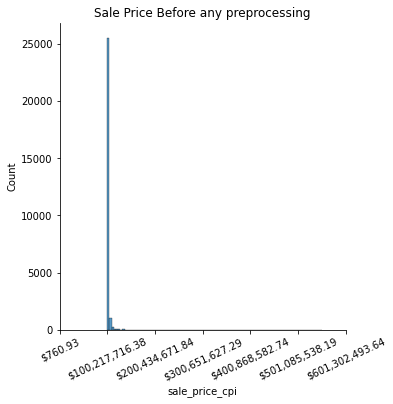

In [37]:
#This function will transform variables into US Currency
prop_func = lambda x: '${:,.2f}'.format(x)

#Plot the sale_price distribution
chart = sns.displot(merged_df['sale_price_cpi'], bins=100)
plt.title('Sale Price Before any preprocessing')
min_price = merged_df['sale_price_cpi'].min()
max_price = merged_df['sale_price_cpi'].max()
steps = (max_price-min_price)/9.0
labels = np.arange(min_price, max_price+1, steps)
labels = map(prop_func, labels)
chart.set(xticklabels=labels)
chart.set_xticklabels(rotation=25);

### Remove outliers and use log transformer on the target variable

In [38]:
#Define a function that calculates the boundaries for a feature
def find_skewed_boundaries(df, var, distance):
    
    IQR = df[var].quantile(.75) - df[var].quantile(.25)
    
    lower_boundary = df[var].quantile(.25) - (distance*IQR)
    upper_boundary = df[var].quantile(.75) + (distance*IQR)
    
    return upper_boundary, lower_boundary

The sale price upper boundary is 3582679.91
Number of observations before removing outliers: 26995
Number of observations after removing outliers: 22043
Removed 4952 observations


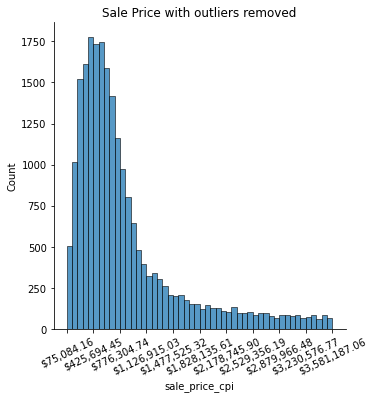

In [39]:
sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(merged_df, 'sale_price_cpi', 1.0)
print(f'The sale price upper boundary is {np.round(sales_upper_boundary,2)}')

#Remove outlier values
obs1 = merged_df.shape[0]
print(f'Number of observations before removing outliers: {obs1}')
merged_df = merged_df.loc[merged_df['sale_price_cpi']<sales_upper_boundary,:]
merged_df = merged_df.loc[merged_df['sale_price_cpi']>75000]
obs2 = merged_df.shape[0]
print(f'Number of observations after removing outliers: {obs2}')
print(f'Removed {obs1-obs2} observations')

#Plot for the sale_price distribution
chart = sns.displot(merged_df['sale_price_cpi'], bins=50)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
skip_step = (merged_df['sale_price_cpi'].max() - merged_df['sale_price_cpi'].min()) / 10
labels = np.round(np.arange(merged_df['sale_price_cpi'].min(), merged_df['sale_price_cpi'].max(), skip_step-1),2)
prop_labels = list(map(prop_func, labels))
chart.set(xticks=labels)
chart.set(xticklabels=prop_labels)
chart.set_xticklabels(rotation=25);

The sale price upper boundary is 1366.94
Number of observations before removing outliers: 22043
Number of observations after removing outliers: 19772
Removed 2271 observations


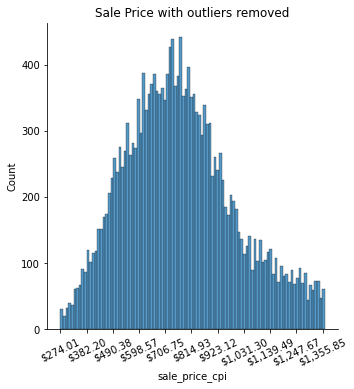

In [40]:
#Power Transformer
et = vt.PowerTransformer(variables = ['sale_price_cpi', 'sale_price'])
et.fit(merged_df)

power_df = et.transform(merged_df)

sales_upper_boundary, sales_lower_boundary = find_skewed_boundaries(power_df, 'sale_price_cpi', 1.0)
print(f'The sale price upper boundary is {np.round(sales_upper_boundary,2)}')

#Remove outlier values
obs1 = power_df.shape[0]
print(f'Number of observations before removing outliers: {obs1}')
power_df = power_df.loc[power_df['sale_price_cpi']<sales_upper_boundary,:]
power_df = power_df.loc[power_df['sale_price_cpi']>sales_lower_boundary]
obs2 = power_df.shape[0]
print(f'Number of observations after removing outliers: {obs2}')
print(f'Removed {obs1-obs2} observations')

#Plot for the sale_price distribution
chart = sns.displot(power_df['sale_price_cpi'], bins=100)
plt.title('Sale Price with outliers removed')
plt.ticklabel_format(style='plain', axis='x')
skip_step = (power_df['sale_price_cpi'].max() - power_df['sale_price_cpi'].min()) / 10
labels = np.round(np.arange(power_df['sale_price_cpi'].min(), power_df['sale_price_cpi'].max(), skip_step-1),2)
prop_labels = list(map(prop_func, labels))
chart.set(xticks=labels)
chart.set(xticklabels=prop_labels)
chart.set_xticklabels(rotation=25);
plt.savefig('Images/sale_price_power_transformation.png')

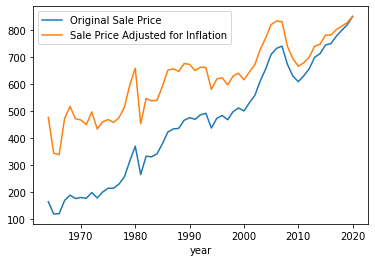

In [41]:
#Below you will see the change in price when adjusting for inflation
fig = plt.figure
real_avg = power_df.groupby('year')['sale_price'].mean().plot(label='Original Sale Price')
adj_avg = power_df.groupby('year')['sale_price_cpi'].mean().plot(label='Sale Price Adjusted for Inflation')
plt.legend()
plt.savefig('Images/sale_price_adjusted.png')

In [42]:
#Determine the age of the property 
power_df['age'] = power_df['date'].dt.year - power_df['year_built']
power_df[['year_built','age']].head()

,year_built,age
0,2008.00000,12.00000
2,1923.00000,97.00000
3,2010.00000,10.00000
4,1990.00000,30.00000
5,1939.00000,81.00000


In [43]:
#Examine the property type feature
temp = pd.concat([power_df.groupby('property_type')['sale_price_cpi'].mean(), power_df.groupby('property_type')['sale_price_cpi'].count(), power_df['property_type'].value_counts(normalize=True)], axis=1)
temp.columns = ['Average sale price','Count', 'Frequency']
temp['Average sale price'] = temp['Average sale price']**2
temp.sort_values(by=['Count'], axis=0,ascending=False, inplace=True)
temp.dropna(inplace=True)
temp['Count'] = temp['Count'].astype(int)
temp['Average sale price'] = temp['Average sale price'].apply(lambda x: '${:,.2f}'.format(x))
temp['Frequency'] = temp['Frequency'].apply(lambda x: "{0:.2f}%".format(x*100))
print(f'Number of categories for property_type: {power_df.property_type.nunique()}')
temp

Number of categories for property_type: 23


,Average sale price,Count,Frequency
Single Family Residence,"$632,900.59",12215,61.78%
Condominium,"$494,630.78",5263,26.62%
"Duplex (2 units, any combination)","$568,360.54",819,4.14%
Planned Unit Development (PUD),"$594,542.55",651,3.29%
"Quadplex (4 Units, Any Combination)","$692,165.90",254,1.28%
"Triplex (3 units, any combination)","$665,757.18",249,1.26%
Apartment house (5+ units),"$892,758.50",215,1.09%
MISCELLANEOUS (Commercial),"$728,018.25",24,0.12%
Residential - Vacant Land,"$708,733.19",21,0.11%
Hotel/Motel,"$596,344.02",16,0.08%


In [44]:
#Remove every property type except Single Family Residence 
num_1 = power_df.shape[0]
print(f'{num_1} total number of houses')
removed_df = power_df.loc[power_df['property_type']!='Single Family Residence']
num_2 = removed_df.shape[0]
print(f'{num_2} number of houses removed')
power_df = power_df.loc[power_df['property_type']=='Single Family Residence']
print(f'{power_df.shape[0]} number of Single Family Residences remain')

19772 total number of houses
7557 number of houses removed
12215 number of Single Family Residences remain


Lot size upper boundary is 17046.0
Number of observations before removing outliers: 12215
Number of observations after removing outliers: 11468
Removed 747 observations


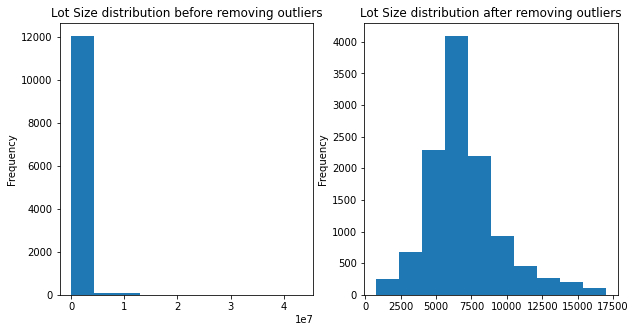

In [45]:
#Remove outliers for lot size
lot_size_upper_boundary, lot_size_lower_boundary = find_skewed_boundaries(power_df, 'lot_size', 3.0)
print(f'Lot size upper boundary is {lot_size_upper_boundary}')

#Remove outlier values
trimmed_df = power_df.loc[power_df['lot_size']<lot_size_upper_boundary,:]
print(f'Number of observations before removing outliers: {power_df.shape[0]}')
print(f'Number of observations after removing outliers: {trimmed_df.shape[0]}')
print(f'Removed {power_df.shape[0]-trimmed_df.shape[0]} observations')

fig, ax = plt.subplots(1,2, figsize=(10,5))

power_df['lot_size'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Lot Size distribution before removing outliers')

trimmed_df['lot_size'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Lot Size distribution after removing outliers')
plt.show()

In [20]:
#Cap the outliers for sex offenders and enviornmental hazards features
windsoriser = Winsorizer(distribution='skewed',
                          tail='right', 
                          fold=1.5,
                          variables=['sex_offenders','enviornmental_hazards'])

windsoriser.fit(trimmed_df)

trimmed_df = windsoriser.transform(trimmed_df)

In [51]:
#Use mean target encoding on the neighborhood feature
neighborhoods = trimmed_df['neighborhood']
mean_enc = MeanCategoricalEncoder(variables=['neighborhood'])

mean_enc.fit(trimmed_df, trimmed_df['sale_price_cpi'])
                                             
trimmed_df = mean_enc.transform(trimmed_df)
trimmed_df['neighborhood_name'] = neigborhoods

In [53]:
ohe_encoder = OneHotCategoricalEncoder(top_categories=7,
                                       variables=['crime_index', 'school_quality'])

ohe_encoder.fit(trimmed_df)

temp = ohe_encoder.transform(trimmed_df)

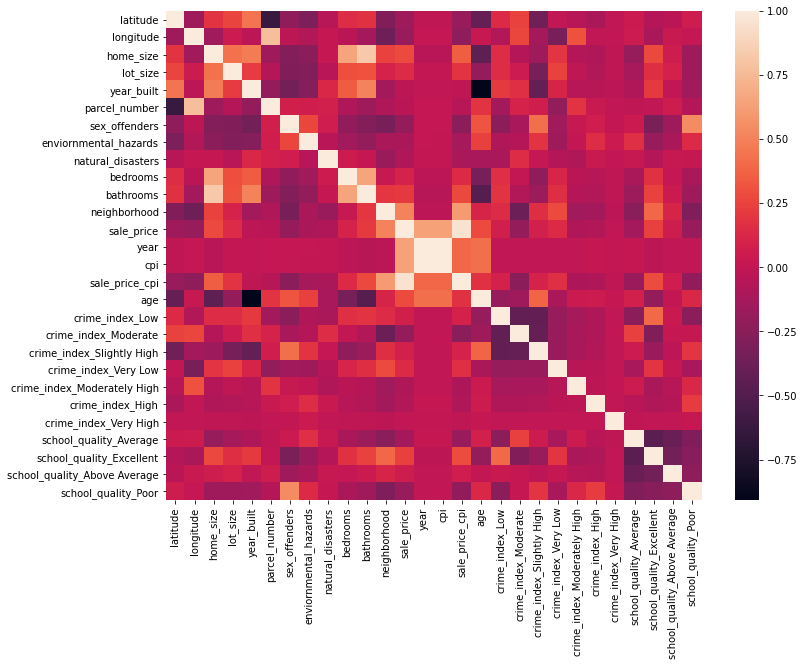

In [54]:
corrmat = temp.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat);

In [55]:
#Identify groups of correlated features
corrmat = trimmed_df.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat

,feature1,feature2,corr
0,year,cpi,0.99891
1,cpi,year,0.99891
2,sale_price,sale_price_cpi,0.95392
3,sale_price_cpi,sale_price,0.95392
4,age,year_built,0.90867
5,year_built,age,0.90867
6,bathrooms,home_size,0.82198
7,home_size,bathrooms,0.82198


In [72]:
#Let's examine crime index
temp = pd.concat([trimmed_df.groupby('crime_index')['sale_price_cpi'].mean(), trimmed_df.groupby('crime_index')['sale_price_cpi'].count()], axis=1)
temp.columns = ['Avg Sale Price \'Power Scale\'', 'Count of crime index type']
temp['Avg Sale Price \'Real Scale\''] = (temp['Avg Sale Price \'Power Scale\''])**2
temp.sort_values(by='Avg Sale Price \'Power Scale\'', ascending=False, inplace=True)
temp['Avg Sale Price \'Power Scale\''] = temp['Avg Sale Price \'Power Scale\''].apply(lambda x: '${:,.2f}'.format(x))
temp['Avg Sale Price \'Real Scale\''] = temp['Avg Sale Price \'Real Scale\''].apply(lambda x: '${:,.2f}'.format(x))
temp

,Avg Sale Price 'Power Scale',Count of crime index type,Avg Sale Price 'Real Scale'
crime_index,,,
Very Low,$926.59,834,"$858,560.35"
Slightly High,$822.85,3255,"$677,082.82"
Low,$818.66,3535,"$670,203.39"
Moderate,$705.14,3339,"$497,219.18"
Moderately High,$671.56,350,"$450,997.13"
High,$622.42,154,"$387,407.80"
Very High,$581.32,1,"$337,932.23"


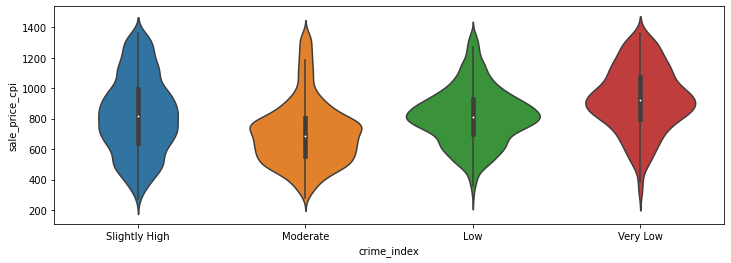

In [71]:
#Box Plot of Crime Index
order=['Slightly High', 'Moderate', 'Low', 'Very Low']
temp = trimmed_df.loc[((trimmed_df['crime_index']!='High') & (trimmed_df['crime_index']!='Moderately High'))]
plt.figure(figsize=(12,4))
sns.violinplot(x='crime_index', y='sale_price_cpi', data=temp, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [70]:
#Let's examine school quality
temp = pd.concat([trimmed_df.groupby('school_quality')['sale_price_cpi'].mean(), trimmed_df.groupby('school_quality')['sale_price_cpi'].count()], axis=1)
temp.columns = ['Average Sale Price Power Scale', 'Count of school_quality types']
#temp['Average Sale Price Real Scale'] = temp['Average Sale Price Power Scale']
temp['Average Sale Price Real Scale'] = temp['Average Sale Price Power Scale']**2
temp.sort_values(by='Average Sale Price Power Scale', ascending=False, inplace=True)
temp['Average Sale Price Power Scale'] = temp['Average Sale Price Power Scale'].apply(lambda x: '${:,.2f}'.format(x))
temp['Average Sale Price Real Scale'] = temp['Average Sale Price Real Scale'].apply(lambda x: '${:,.2f}'.format(x))
temp

,Average Sale Price Power Scale,Count of school_quality types,Average Sale Price Real Scale
school_quality,,,
Excellent,$890.04,3282,"$792,163.07"
Above Average,$815.51,2636,"$665,057.28"
Average,$732.09,3908,"$535,961.25"
Poor,$669.45,1642,"$448,168.70"


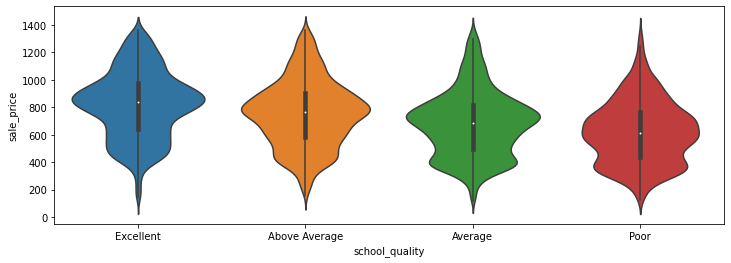

In [59]:
#Box Plot of School Quality
order=['Excellent', 'Above Average', 'Average', 'Poor']
temp = trimmed_df.copy()
plt.figure(figsize=(12,4))
sns.violinplot(x='school_quality', y='sale_price', data=temp, order=order)
plt.ticklabel_format(style='plain', axis='y')

In [68]:
trimmed_df.head()

,latitude,longitude,address,property_type,home_size,lot_size,year_built,parcel_number,zoning,sex_offenders,crime_index,enviornmental_hazards,natural_disasters,school_quality,url,bedrooms,bathrooms,geometry,neighborhood,date,sale_price,sold_date,year,cpi,sale_price_cpi,age,neighborhood_name
5,33.80319,-118.20101,2524 Oregon Ave,Single Family Residence,2079.00000,6223.00000,1939.00000,7202014015,LBR1N,25,Slightly High,6,2,Average,https://www.realtytrac.com/property/ca/long-be...,2.00000,2.00000,POINT (-118.20101 33.80319),790.80732,2020-12-01,886.00226,2020-12-09,2020,261.22900,885.61383,81.00000,Long Beach
6,33.77416,-118.39710,28703 Cedarbluff Dr,Single Family Residence,1780.00000,12098.00000,1964.00000,7583015003,RPRS10000,2,Very Low,2,2,Excellent,https://www.realtytrac.com/property/ca/rancho-...,3.00000,2.00000,POINT (-118.39710 33.77416),1074.94813,2020-12-01,1238.95117,2020-12-09,2020,261.22900,1238.40800,56.00000,Rancho Palos Verdes
8,33.76664,-118.16535,2116 E Broadway,Single Family Residence,948.00000,3140.00000,1913.00000,7264029029,LBCNP,13,Slightly High,3,1,Average,https://www.realtytrac.com/property/ca/long-be...,2.00000,1.00000,POINT (-118.16535 33.76664),790.80732,2020-12-01,836.66003,2020-12-09,2020,261.22900,836.29323,107.00000,Long Beach
11,34.04556,-118.37916,1773 S Corning St,Single Family Residence,1972.00000,5986.00000,1938.00000,4303025013,LAR1,6,Slightly High,5,1,Average,https://www.realtytrac.com/property/ca/los-ang...,3.00000,2.00000,POINT (-118.37916 34.04556),968.78080,2020-12-01,1284.52326,2020-12-09,2020,261.22900,1283.96011,82.00000,Pico-Robertson
12,34.10207,-118.18821,415 Kendall Ave,Single Family Residence,1669.00000,6398.00000,1903.00000,5301007029,LAR1,8,Slightly High,4,1,Average,https://www.realtytrac.com/property/ca/los-ang...,3.00000,2.00000,POINT (-118.18821 34.10207),790.71857,2020-12-01,1040.19229,2020-12-09,2020,261.22900,1039.73626,117.00000,Montecito Heights


In [75]:
#Create a dataset with just unique houses
drop_features = ['address','year_built', 'parcel_number', 'date', 'property_type', 'url', 'year', 'cpi', 'natural_disasters', 'zoning']
houses = trimmed_df.sort_values(by='date', ascending=False).reset_index(drop=True)
print(f'Number of observations before removing duplicate houses {houses.shape[0]}')
houses = houses.drop_duplicates(subset='address')
houses.drop(drop_features, axis=1, inplace=True)
houses.rename(columns={'sold_date': 'date'}, inplace=True)
houses['sale_price'] = houses['sale_price']**2
print(f'Number of observations after removing duplicate houses {houses.shape[0]}')
houses.to_csv('Data/houses.csv', index=False)

Number of observations before removing duplicate houses 11468
Number of observations after removing duplicate houses 6115


In [74]:
#Lets remove the features that won't be needed for the model
drop_features = ['address','year_built', 'parcel_number','date', 'sold_date', 'property_type', 'url', 'year', 'cpi', 'natural_disasters', 'zoning', 'neighborhood_name']
final_df = trimmed_df.drop(drop_features, axis=1)
final_df.to_csv('Data/house_data_details_eda.csv', index=False)